# Making Necessary Imports

In [1]:
import json
import math
import multiprocessing as mp
import os
import pickle
from collections import defaultdict
from functools import partial
from multiprocessing.pool import ThreadPool

import numpy as np
import pandas as pd
import spacy
import spacy_fastlang
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

tqdm.pandas()
pd.options.mode.chained_assignment = None


In [2]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import (LSTM, AdditiveAttention, Bidirectional,
                                     Concatenate, Conv1D, Dense, Embedding,
                                     GlobalMaxPooling1D, Input, Lambda, Layer)
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import Sequence, plot_model


# Data processing

## 1. Reading json file

In [28]:
if not os.path.exists('reviews.csv'):
    reviews_file = open('review.txt', 'rb')
    reviews = reviews_file.readlines()
    reviews_file.close()
    reviews_data = {"text": [], "overall": [], "service":[], "cleanliness":[], "value": [], "location": [], "sleep_quality": []}

    for review in tqdm(reviews):
        review_data = json.loads(review)
        reviews_data["text"].append(review_data['text'])
        review_ratings = defaultdict(lambda :0, review_data['ratings'])
        for key in reviews_data.keys():
            if key != 'text':
                reviews_data[key].append(review_ratings[key])

    reviews_df = pd.DataFrame(reviews_data)
    reviews_df.to_csv('reviews.csv', index=False)

reviews_df = pd.read_csv('reviews.csv')
reviews_df.head()

,text,overall,service,cleanliness,value,location,sleep_quality
0,Stayed in a king suite for 11 nights and yes i...,5.0,5.0,5.0,5.0,5.0,5.0
1,"On every visit to NYC, the Hotel Beacon is the...",5.0,5.0,5.0,5.0,5.0,5.0
2,This is a great property in Midtown. We two di...,4.0,4.0,5.0,4.0,5.0,4.0
3,The Andaz is a nice hotel in a central locatio...,4.0,5.0,5.0,5.0,5.0,5.0
4,I have stayed at each of the US Andaz properti...,4.0,4.0,5.0,3.0,5.0,5.0


## 2. Filtering out non-english reviews

In [11]:
eng = spacy.load('en_core_web_sm',  disable=['tagger', 'ner'])
eng.add_pipe('language_detector', name='language_detector', last=True)

review_lang = reviews_df['text'].progress_apply(lambda x: eng(x)._.language)
with open('lang.pkl', 'wb') as f:
    pickle.dump(review_lang, f)

  0%|          | 0/878561 [00:00<?, ?it/s]

TypeError: file must have a 'write' attribute

In [29]:
if os.path.exists('lang.pkl'):
    lang_file = open('lang.pkl', 'rb')
    review_lang = pickle.load(lang_file)
    lang_file.close()

review_lang[:5]

0    en
1    en
2    en
3    en
4    en
Name: text, dtype: object

In [30]:
reviews_df = reviews_df[review_lang == 'en']
reviews_df.head()

,text,overall,service,cleanliness,value,location,sleep_quality
0,Stayed in a king suite for 11 nights and yes i...,5.0,5.0,5.0,5.0,5.0,5.0
1,"On every visit to NYC, the Hotel Beacon is the...",5.0,5.0,5.0,5.0,5.0,5.0
2,This is a great property in Midtown. We two di...,4.0,4.0,5.0,4.0,5.0,4.0
3,The Andaz is a nice hotel in a central locatio...,4.0,5.0,5.0,5.0,5.0,5.0
4,I have stayed at each of the US Andaz properti...,4.0,4.0,5.0,3.0,5.0,5.0


## 3. Removing reviews with length less than 50 and greater than 1000

In [31]:
reviews_len = reviews_df['text'].progress_map(lambda x: len(x.split()))

print(f"Reviews with less than 50 words: {sum(reviews_len<=50)}")
print(f"Reviews with more than 1000 words: {sum(reviews_len>=1000)}")
print(f"Reviews with more than 50 words and less than 1000: {sum((reviews_len>50) & (reviews_len<1000))}")

reviews_df = reviews_df[(reviews_len>50) & (reviews_len<1000)]

  0%|          | 0/770904 [00:00<?, ?it/s]

Reviews with less than 50 words: 103631
Reviews with more than 1000 words: 1235
Reviews with more than 50 words and less than 1000: 666038


## 4. Expanding contractions, removing non-textual data and numbers from the text reviews

In [32]:
# referred this dictionary for contractions expansion: https://stackoverflow.com/questions/43018030/replace-apostrophe-short-words-in-python

contractions = {"ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because", "could've": "could have", "couldn't": "could not", "couldn't've": "could not have",
"didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", "he'd": "he had", "he'd've": "he would have",
"he'll": "he shall", "he'll've": "he will have", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "i'd": "I had",
"i'd've": "I would have", "i'll": "I will", "i'll've": "I will have", "i'm": "I am", "i've": "I have", "isn't": "is not", "it'd": "it had", "it'd've": "it would have", "it'll": "it will",
"it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have",
"must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
"shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she had", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
"she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have", "so's": "so is", "that'd": "that had", "that'd've": "that would have",
"that's": "that is", "there'd": "there had", "there'd've": "there would have", "there's": "there is", "they'd": "they had", "they'd've": "they would have",
"they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we had", "we'd've": "we would have",
"we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
"what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
"who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
"would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have",
"you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"
}

In [33]:
def expand_contractions(text):
    words = text.split()
    return ' '.join([x if x.lower() not in contractions else contractions[x.lower()] for x in words])
reviews_df['text'] = reviews_df['text'].progress_apply(expand_contractions)
reviews_df.head()

  0%|          | 0/666038 [00:00<?, ?it/s]

,text,overall,service,cleanliness,value,location,sleep_quality
0,Stayed in a king suite for 11 nights and yes i...,5.0,5.0,5.0,5.0,5.0,5.0
1,"On every visit to NYC, the Hotel Beacon is the...",5.0,5.0,5.0,5.0,5.0,5.0
2,This is a great property in Midtown. We two di...,4.0,4.0,5.0,4.0,5.0,4.0
3,The Andaz is a nice hotel in a central locatio...,4.0,5.0,5.0,5.0,5.0,5.0
4,I have stayed at each of the US Andaz properti...,4.0,4.0,5.0,3.0,5.0,5.0


In [34]:
import re
import string

class Preprocesser(object):
    def __init__(self, url=True, number=True):
        self.url = url
        self.number = number
    
    def apply(self, text):
        text = self._lowercase(text)
        if self.url:
            text = self._remove_url(text)
        if self.number:
            text = self._remove_number(text)
        text = re.sub(r'\s+', ' ', text)
        return text
    
        
    def _remove_punctuation(self, text):
        puncs = string.punctuation
        text = ''.join(c for c in text if c not in puncs)
        return text
    
    def _remove_url(self, text):
        text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text)
        return text
    
    def _remove_number(self, text):
        text = ''.join([i for i in text if not i.isdigit()])        
        return text
    
    def _lowercase(self, text):
        return text

preprocesser = Preprocesser()

In [35]:
reviews_df['text'] = reviews_df['text'].progress_apply(preprocesser.apply)

  0%|          | 0/666038 [00:00<?, ?it/s]

## 5. Lemmatizing the data

In [42]:
en = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def process_doc(df: pd.DataFrame,  progressbar, batch_size:int=1000):
    docs_gen = en.pipe(df['text'], n_process=4, batch_size=batch_size)
    processed_text = []
    for i, doc in tqdm(enumerate(docs_gen), total=len(df), desc=f'Lemmatizing from {df.index[0]} to {df.index[-1]}', leave=False):
        processed_text.append(' '.join([tokens.lemma_ for tokens in doc if not tokens.is_stop or tokens.text == 'not']))
    df['text'] = processed_text
    progressbar.update(1)
    return df
        
def lemmatize_data(df:pd.DataFrame, batch_size=1000):
    n_process = (3*mp.cpu_count())//4
    print(f"[Info] CPU count: {mp.cpu_count()}")
    print(f"[Info] No. of Threads: {n_process}")
    data_splits = [df[i*batch_size:(i+1)*batch_size] for i in range(math.ceil(len(df)/batch_size))]
    print(f"[Info] Data splits generated. No of data splits: {len(data_splits)}")

    progress = tqdm(total=len(data_splits), desc='Processed dataframes')
    new_df = pd.concat([x for x in ThreadPool(n_process).imap_unordered(partial(process_doc, progressbar=progress, batch_size=batch_size), data_splits)])

    return new_df

In [3]:
if not os.path.exists('processed.csv'):
    reviews_df = lemmatize_data(reviews_df)
    reviews_df.to_csv('processed.csv', index=False)

else:
    reviews_df = pd.read_csv('processed.csv')

In [4]:
reviews_df.head(10)

,text,overall,service,cleanliness,value,location,sleep_quality,processed_text
0,. This Hotel is a beautiful and the check in p...,4.0,5.0,4.0,5.0,4.0,5.0,. Hotel beautiful check process smooth quick a...
1,"Classy, Clean and Courteous. Beautiful facilit...",4.0,5.0,5.0,4.0,5.0,5.0,"Classy , Clean Courteous . beautiful facility ..."
2,We stayed here one night to test drive the hea...,5.0,5.0,5.0,5.0,5.0,5.0,stay night test drive heavenly bed not bed sta...
3,Our family stayed at the Hilton Americas in Ho...,5.0,5.0,5.0,3.0,5.0,5.0,family stay Hilton Americas Houston week . wif...
4,Stayed at the hotel for a SBA lenders conferen...,5.0,5.0,5.0,5.0,5.0,5.0,stay hotel SBA lender conference . Eveyone com...
5,I stayed here one night while in town for a co...,4.0,4.0,5.0,3.0,5.0,5.0,stay night town conference . connect conventio...
6,I have stayed at the Hilton Garden Inn on Katy...,5.0,5.0,5.0,5.0,5.0,5.0,stay Hilton Garden Inn Katy Freeway time busin...
7,My husband and I were working on our house las...,5.0,5.0,5.0,5.0,5.0,5.0,husband work house month stay hotel night . ha...
8,I recently spent three weeks at this hotel ove...,5.0,5.0,5.0,5.0,4.0,5.0,recently spend week hotel month period . staff...
9,Most of the time when you go to a hotel you ca...,4.0,5.0,5.0,5.0,5.0,5.0,time hotel tell not manager staff care please ...


In [5]:
X = reviews_df.loc[:, 'processed_text'].to_numpy()
y = reviews_df.iloc[:, 1:7].to_numpy()

# Visualization of categories count

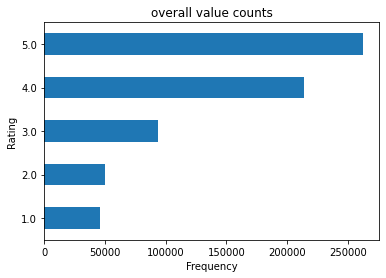

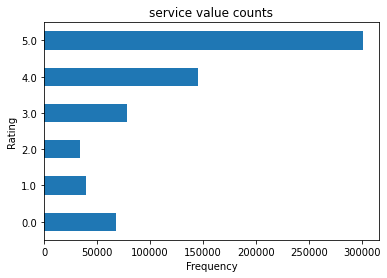

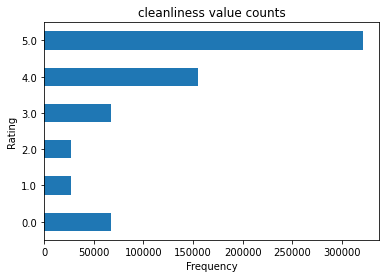

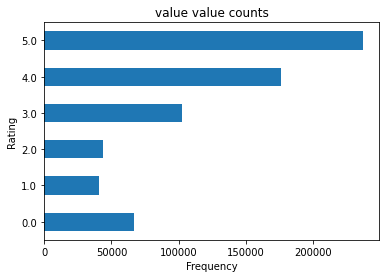

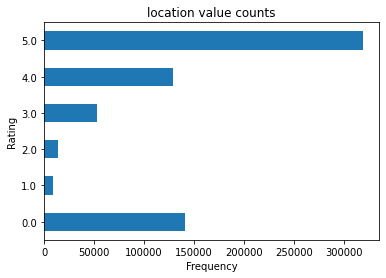

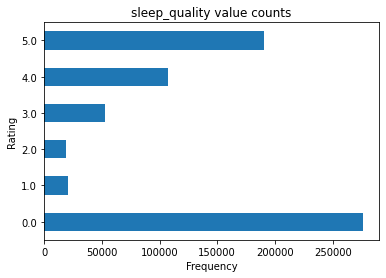

In [47]:
attr = ['overall', 'service', 'cleanliness', 'value', 'location', 'sleep_quality']

for atr in attr:
    plt.title(f"{atr} value counts")
    plt.xlabel('Frequency')
    plt.ylabel('Rating')
    reviews_df[atr].value_counts().sort_index().plot(kind='barh')
    plt.show()

# Tokenization and Model Generation

In [6]:
tf_tokenizer = Tokenizer()
tf_tokenizer.fit_on_texts(X)

## 1. Model Paramteres

In [7]:
text_window = 1000
embedding_dim = 128
lstm_cell_units = 100
batch_size = 256
source_vocab_size = len(tf_tokenizer.word_counts)
epochs = 10
learning_rate = 0.001
dropout_prob = 0.3
cnn1_window = [10]*6
cnn2_window = [5]*6
cnn_filters = 256

## 2. Data generator

In [8]:
class DataGen(Sequence):
    def __init__(self, data, labels, tokenizer, batch_size, text_window):
        self.data = data
        self.labels = labels
        self.tokenzier = tokenizer
        self.batch_size = batch_size
        self.text_window = text_window

    def __len__(self):
        return math.ceil(len(self.data)/self.batch_size)

    def __getitem__(self, idx:int):
        batch_data = self.data[idx*self.batch_size: (idx+1)*self.batch_size]
        batch_labels = self.labels[idx*self.batch_size: (idx+1)*self.batch_size]
        batch_tokens = self.tokenzier.texts_to_sequences(batch_data)
        batch_tokens = pad_sequences(batch_tokens, maxlen=self.text_window, padding='post')

        overall_output = batch_labels[:,0]
        service_output = batch_labels[:,1]
        cleanliness_output = batch_labels[:, 2]
        value_output = batch_labels[:, 3]
        location_output = batch_labels[:, 4]
        sleep_output = batch_labels[:, 5]
        
        return batch_tokens, np.column_stack((overall_output, service_output, cleanliness_output, value_output, location_output, sleep_output))

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [10]:
train_gen = DataGen(X_train, y_train, tf_tokenizer, batch_size, text_window)
test_gen = DataGen(X_test, y_test, tf_tokenizer, batch_size, text_window)

## 3. CNN BiLSTM Model without attention

In [54]:
input_layer = Input(shape=(text_window, ), dtype=tf.int64)

x = Embedding(source_vocab_size+1, embedding_dim, mask_zero=True, name='EmbeddingLayer')(input_layer)
x = Bidirectional(LSTM(lstm_cell_units, return_state=False, return_sequences=True, name='LSTMLayer1'))(x)
x = Bidirectional(LSTM(lstm_cell_units, return_state=False, return_sequences=True, name='LSTMLayer2'))(x)

x = Concatenate(name='Concatenate')([
    GlobalMaxPooling1D(name='Pooling_%i'%i)(
        Conv1D(cnn_filters, cnn2_window[i], name='ConvLayer2_%d'%i)(Conv1D(cnn_filters, cnn1_window[i], name='ConvLayer1_%d'%i)(x))) for i in range(len(cnn1_window))
])

overall_output_layer = Lambda(tf.expand_dims, arguments={'axis':1})(Dense(6, activation='softmax', name='OverallLayer')(x))
service_output_layer = Lambda(tf.expand_dims, arguments={'axis':1})(Dense(6, activation='softmax', name='ServiceLayer')(x))
cleanliness_output_layer = Lambda(tf.expand_dims, arguments={'axis':1})(Dense(6, activation='softmax', name='CleanlinessLayer')(x))
value_output_layer = Lambda(tf.expand_dims, arguments={'axis':1})(Dense(6, activation='softmax', name='ValueLayer')(x))
location_output_layer = Lambda(tf.expand_dims, arguments={'axis':1})(Dense(6, activation='softmax', name='LocationLayer')(x))
sleep_output_layer = Lambda(tf.expand_dims, arguments={'axis':1})(Dense(6, activation='softmax', name='SleepLayer')(x))

output_layer = Concatenate(axis=1)([overall_output_layer, service_output_layer, cleanliness_output_layer, value_output_layer, location_output_layer, sleep_output_layer])


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-05-13 03:47:58.378996: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-13 03:47:58.379531: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [55]:
noAttMod = Model(input_layer, output_layer)
noAttMod.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=True, reduction='none'), metrics=['accuracy'])
noAttMod.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 EmbeddingLayer (Embedding)     (None, 1000, 128)    22289024    ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 1000, 200)    183200      ['EmbeddingLayer[0][0]']         
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 1000, 200)   240800      ['bidirectional[0][0]']          
 )                                                                                            

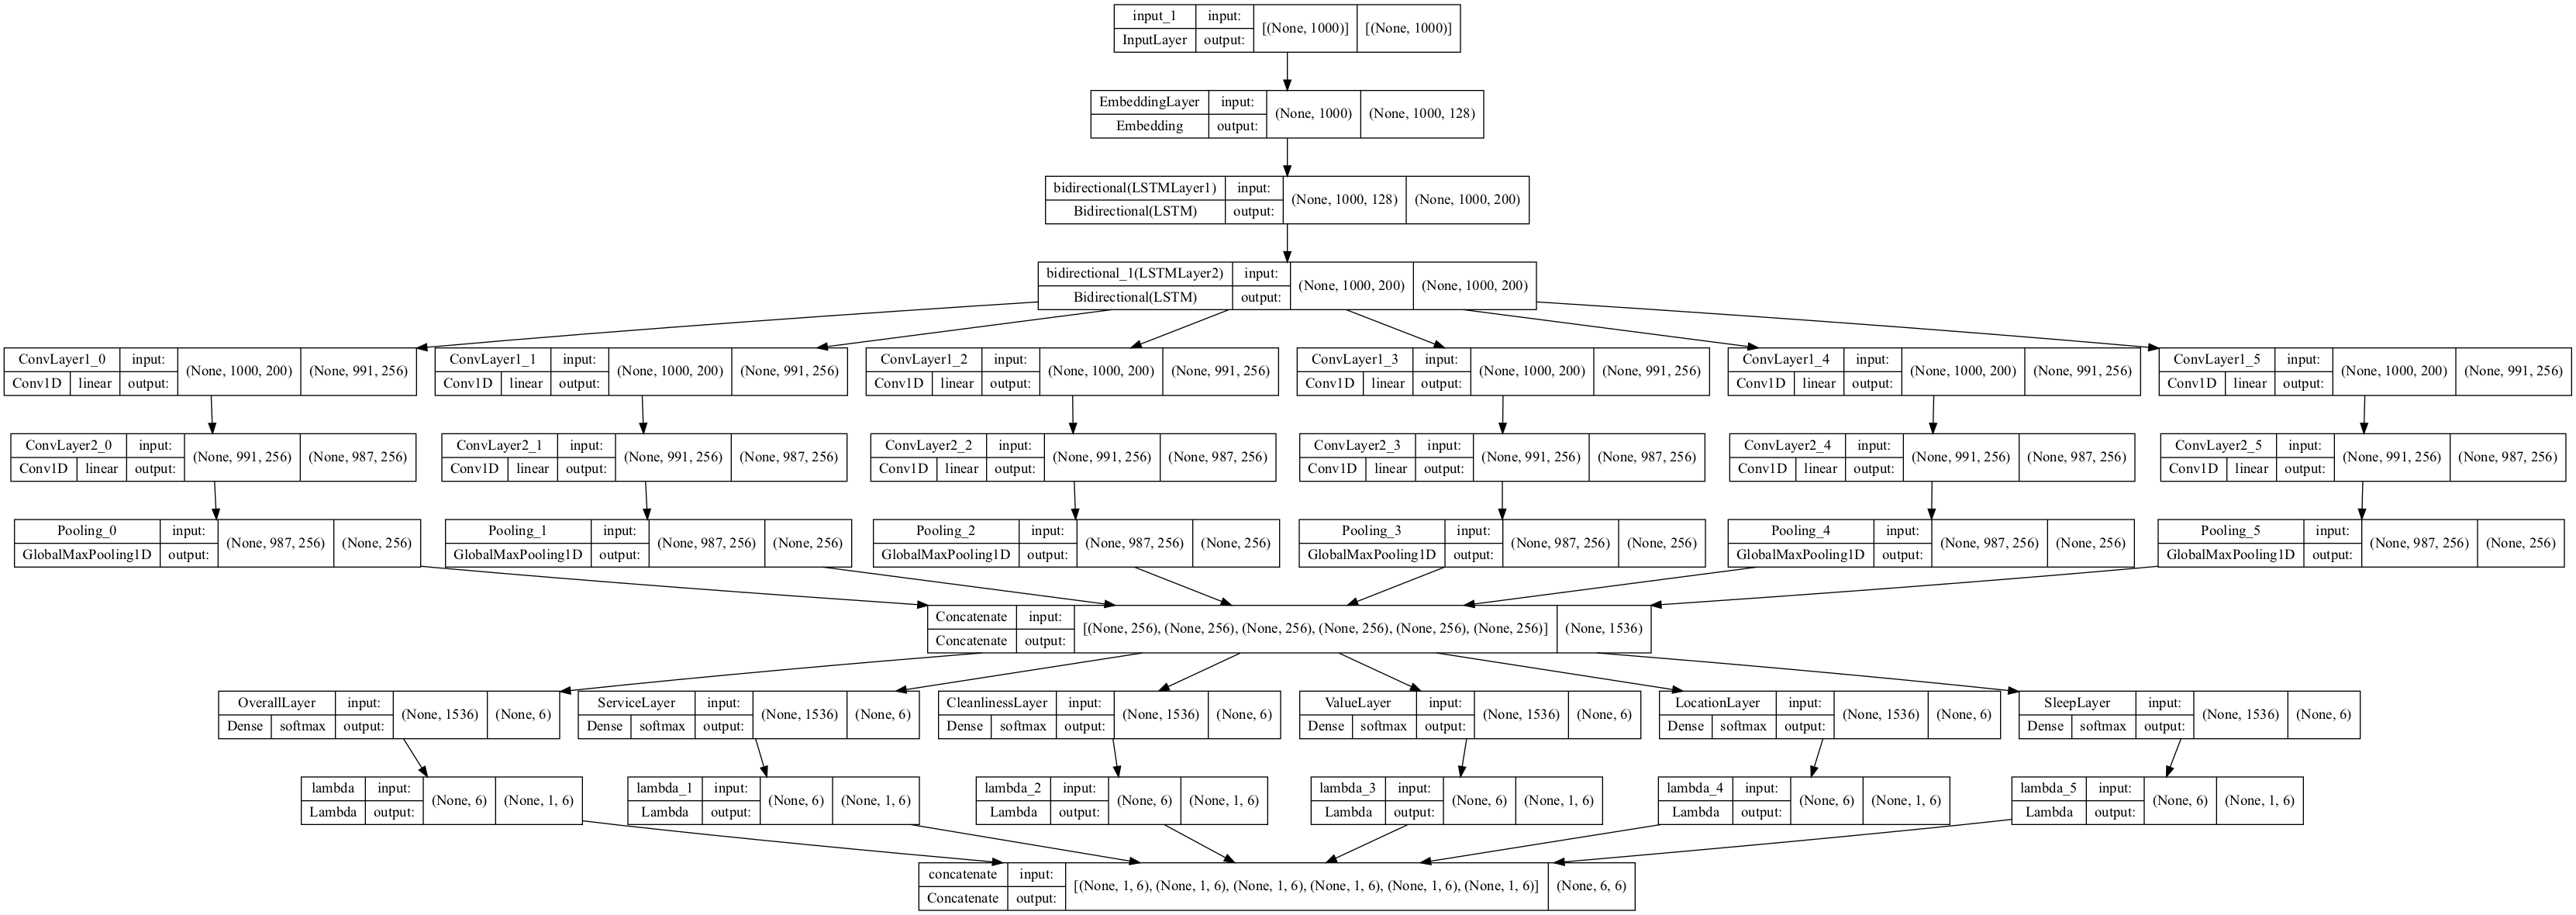

In [56]:
plot_model(noAttMod, "without_attention_model.png", show_layer_names=True, show_shapes=True, show_layer_activations=True)

In [57]:
noAttMod.fit(train_gen, epochs=epochs, validation_data=test_gen, callbacks=ModelCheckpoint('NoAttModel', save_best_only=True))

Epoch 1/10


2022-05-13 03:48:14.513271: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-13 03:48:24.458039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-13 03:48:26.697908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-13 03:48:26.699281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-13 03:48:35.931596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-13 03:48:36.134999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-13 03:48:44.008812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

  32/1952 [..............................] - ETA: 4:40:26 - loss: 1.6404 - accuracy: 0.4030

KeyboardInterrupt: 

## 4. CNN BiLSTM Model with attention

In [11]:
class Attention(Layer):
    def __init__(self, units, **kwargs):
        super(Attention, self).__init__(**kwargs)
        
        self.query_dense_layer = Dense(units, name='QueryDense')
        self.value_dense_layer = Dense(units, use_bias=False, name='ValueDense')

        self.attention_layer = AdditiveAttention(name='AdditiveAttention')
        
    def call(self, query, value, mask):
        return self.get_stacked_layers(query, value, mask)
    
    def get_stacked_layers(self, query, value, mask):
        query_dense = self.query_dense_layer(query)
        value_dense = self.value_dense_layer(value)

        mask = [
            tf.ones(tf.shape(query)[:-1], dtype=bool),
            mask
        ]
        context_vector, attention_weights = self.attention_layer(
            inputs = [query_dense, value_dense],
            mask = mask,
            return_attention_scores = True
        )
        
        return context_vector, attention_weights

In [12]:
input_layer = Input(shape=(text_window, ), dtype=tf.int64)

x = Embedding(source_vocab_size+1, embedding_dim, mask_zero=True, name='EmbeddingLayer')(input_layer)
x = Bidirectional(LSTM(lstm_cell_units, return_state=False, return_sequences=True, name='LSTMLayer1'))(x)
x = Bidirectional(LSTM(lstm_cell_units, return_state=False, return_sequences=True, name='LSTMLayer2'))(x)

cnn_output = Concatenate(axis=1)([Lambda(tf.keras.backend.expand_dims, arguments={'axis':1})(GlobalMaxPooling1D()(Conv1D(cnn_filters, cnn2_window[i], name='ConvLayer2_%d'%i)
                (Conv1D(cnn_filters, cnn1_window[i], name='ConvLayer1_%d'%i)(x)))) for i in range(len(cnn1_window))])

context, score = Attention(10)(cnn_output, x, input_layer!=0)

x = Concatenate(axis=-1)([cnn_output, context])
output_layer = Dense(6, activation='softmax', name='OutputDenseLayer')(x)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-05-13 19:12:09.447443: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-13 19:12:09.447697: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
attMod = Model(input_layer, output_layer)

In [14]:
optimizer = Adam(learning_rate)
attMod.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=True, reduction='none'), metrics=['accuracy'])
attMod.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 EmbeddingLayer (Embedding)     (None, 1000, 128)    22289024    ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 1000, 200)    183200      ['EmbeddingLayer[0][0]']         
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 1000, 200)   240800      ['bidirectional[0][0]']          
 )                                                                                            

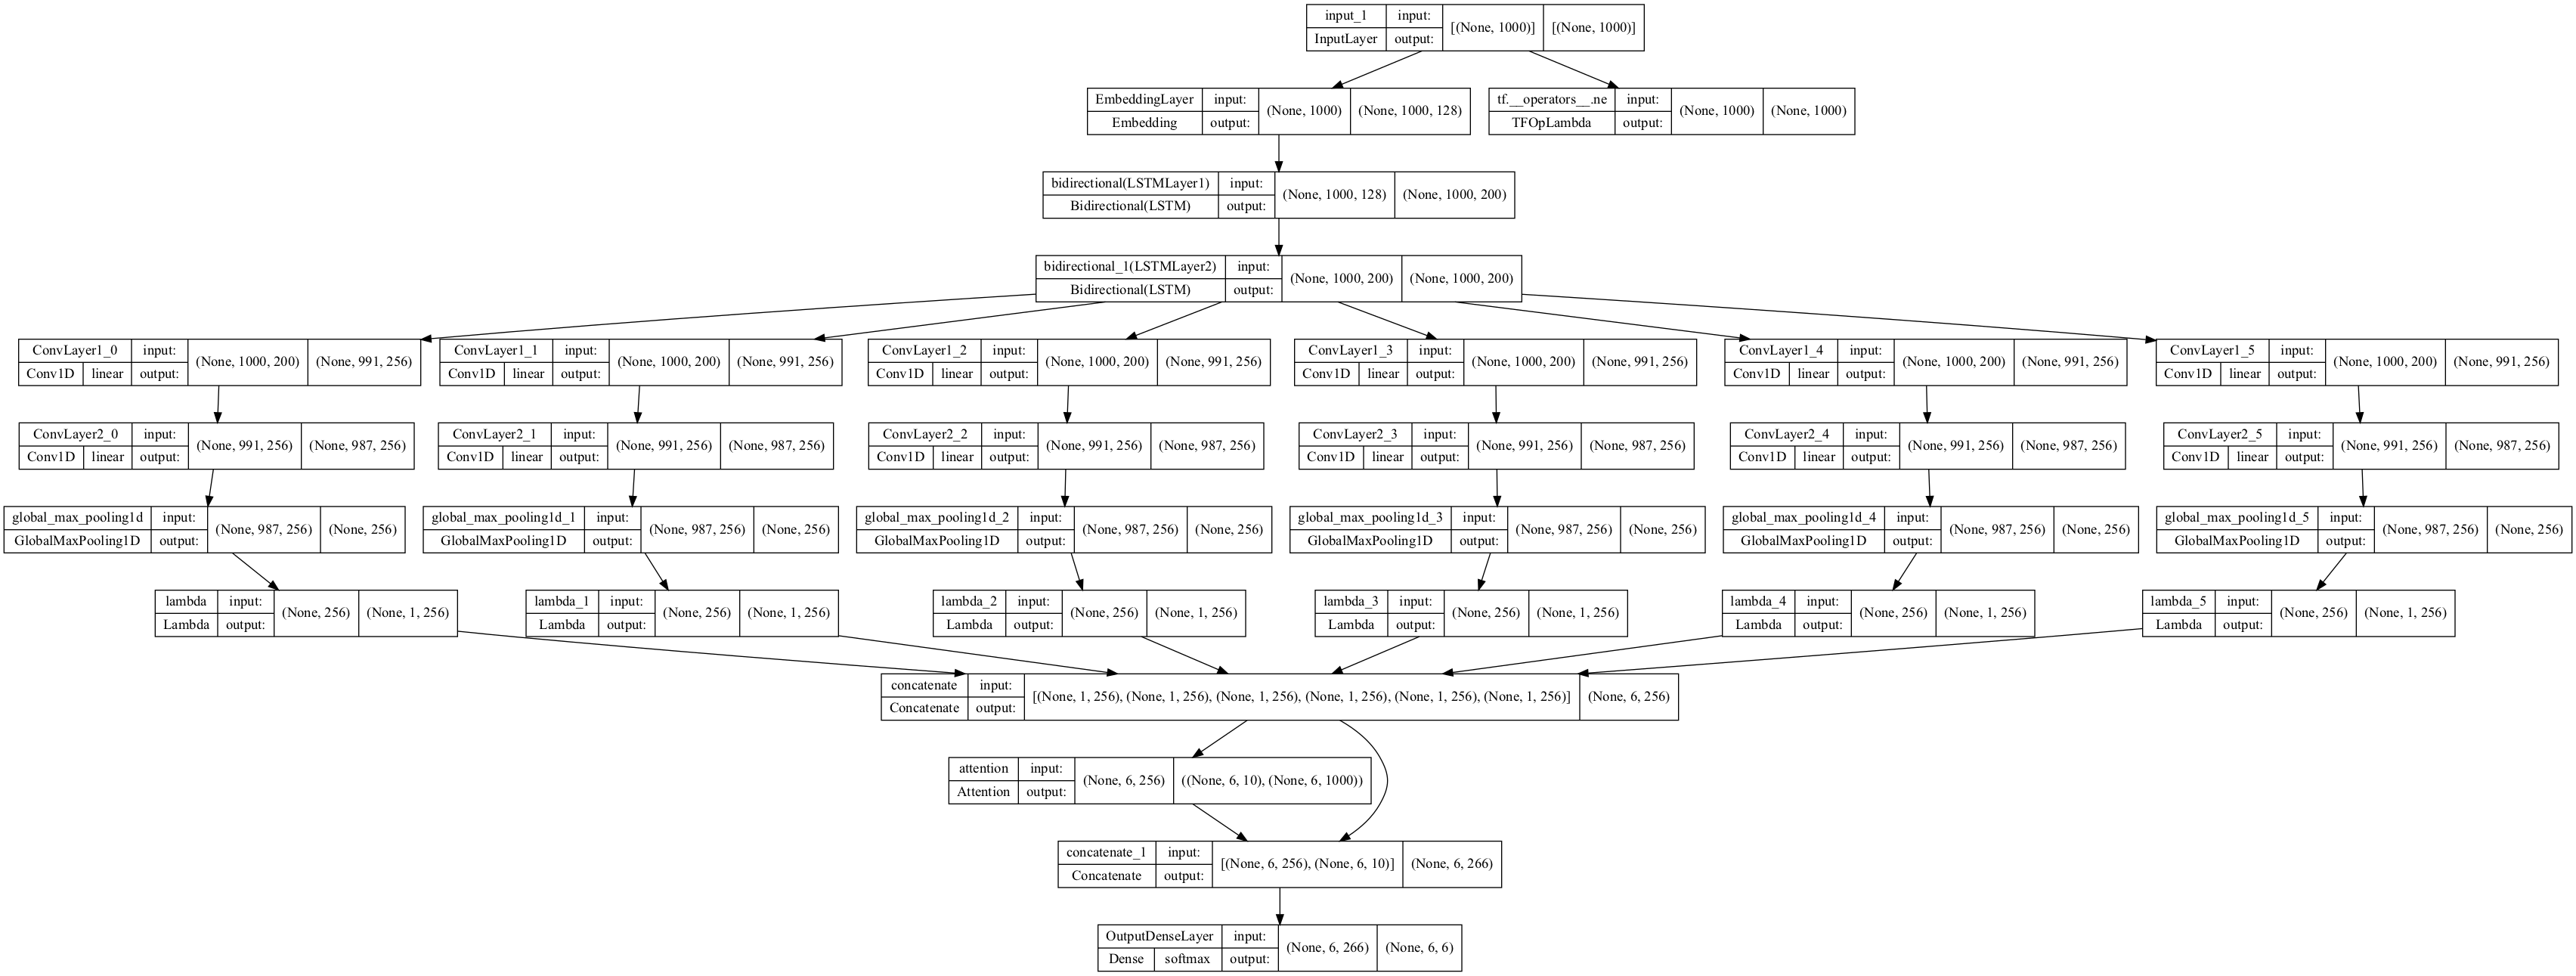

In [15]:
plot_model(attMod, "attention_model.png", show_layer_names=True, show_shapes=True, show_layer_activations=True)

In [16]:
attMod.fit(train_gen, epochs=epochs, validation_data=test_gen, callbacks=ModelCheckpoint('AttModel', save_best_only=True))

Epoch 1/10


2022-05-13 19:12:38.875738: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/Users/varunreddy/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
2022-05-13 19:12:45.545997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-13 19:12:47.299113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-13 19:12:47.299288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-13 19:12:53.215277: I tensorflow/core/g

  30/1952 [..............................] - ETA: 5:38:27 - loss: 1.4777 - accuracy: 0.4228

KeyboardInterrupt: 